# ROC-curves

Python script for illustrating ROC curves with Gaussian examples - WITH ANIMATION.
To better understand the code in this notebook, see MakeROCfigure.ipynb.  

### Authors: 
- Christian Michelsen (Niels Bohr Institute)
- Troels C. Petersen (minor) (Niels Bohr Institute)

### Date:    
- 07-12-2022 (latest update)

***

In [34]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at

Then set up variables for the program:

In [35]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

N_entries  = 10000
verbose = False

Functions:

In [36]:
# Calculate ROC curve from two histograms (hist1 is signal, hist2 is background):
def calc_ROC(hist1, hist2) :

    # First we extract the entries (y values) and the edges of the histograms
    y_sig, x_sig_edges, _ = hist1 
    y_bkg, x_bkg_edges, _ = hist2
    
    # Check that the two histograms have the same x edges:
    if np.array_equal(x_sig_edges, x_bkg_edges):
        
        # Extract the center positions (x values) of the bins (both signal or background works - equal binning)
        x_centers = 0.5*(x_sig_edges[1:] + x_sig_edges[:-1])
        
        # Calculate the integral (sum) of the signal and background:
        integral_sig = y_sig.sum()
        integral_bkg = y_bkg.sum()
    
        # Initialize empty arrays for the True Positive Rate (TPR) and the False Positive Rate (FPR):
        TPR = np.zeros_like(y_sig) # True positive rate (sensitivity)
        FPR = np.zeros_like(y_sig) # False positive rate ()
        
        # Loop over all bins (x_centers) of the histograms and calculate TN, FP, FN, TP, FPR, and TPR for each bin:
        for i, x in enumerate(x_centers): 
            
            # The cut mask
            cut = (x_centers < x)
            
            # True positive
            TP = np.sum(y_sig[~cut]) / integral_sig    # True positives
            FN = np.sum(y_sig[cut]) / integral_sig     # False negatives
            TPR[i] = TP / (TP + FN)                    # True positive rate
            
            # True negative
            TN = np.sum(y_bkg[cut]) / integral_bkg      # True negatives (background)
            FP = np.sum(y_bkg[~cut]) / integral_bkg     # False positives
            FPR[i] = FP / (FP + TN)                     # False positive rate            

        return FPR, TPR, x_centers, y_sig, y_bkg
    
    else:
        AssertionError("Signal and Background histograms have different bins and ranges")

#### Function to interpolate the histograms:

In [37]:
def interpolate_histogram(x_centers, counts, N=1000):
    binwidth = np.diff(x_centers)[0]
    xmin = x_centers[0] - binwidth / 2 
    xmax = x_centers[-1] + binwidth / 2
    
    x = np.linspace(xmin, xmax, N)
    y = np.zeros(N)
    
    for i in range(len(x_centers)-1):
        x_i1 = x_centers[i] - binwidth / 2 
        x_i2 = x_centers[i+1] - binwidth / 2 
        mask = (x_i1 <= x) & (x < x_i2)
        y[mask] = counts[i]
    return x, y, binwidth

In [38]:
# Below we use special parts of matplotlib:
import matplotlib.path as mpath
import matplotlib.patches as mpatches

def fill_histograms(i):

    mask = (x_hist_interp <= x_centers[i]) # - binwidth/2)

    verts_sig, codes_sig = create_verts_for_hist(x_hist_interp[mask], y_sig_interp[mask])
    verts_bkg, codes_bkg = create_verts_for_hist(x_hist_interp[mask], y_bkg_interp[mask])

    patch_sig = mpatches.PathPatch(mpath.Path(verts_sig, codes_sig), facecolor='C3', alpha=0.8)
    patch_bkg = mpatches.PathPatch(mpath.Path(verts_bkg, codes_bkg), facecolor='C0', alpha=0.99)
    ax[0].add_patch(patch_bkg)
    ax[0].add_patch(patch_sig)
    
    return None

In [39]:
def create_verts_for_hist(x, y):
    
    N = len(x)
    M = 2*N+3
    verts = np.zeros((M, 2))
    codes = np.zeros(M, dtype=np.uint8)
    
    verts[0, 0] = verts[-1, 0] = x[0]
    verts[1:N+1, 0] = x
    verts[N+1, 0] = x[-1]
    verts[N+2:-1, 0] = x[::-1]
    
    verts[0, 1] = verts[-1, 1] = y[0]
    verts[1:N+1, 1] = y

    codes[0] = 1
    codes[1:-1] = 2
    codes[-1] = 79
    
    return verts, codes

## Gaussian distributions (signal & background) of varying separation

In [47]:
N_sigma = 2.0 

mean_sig = 5 + N_sigma / np.sqrt(2.0)
mean_bkg = 5 - N_sigma / np.sqrt(2.0)

random_sig = r.normal(loc=mean_sig, scale=1, size=N_entries)
random_bkg = r.normal(loc=mean_bkg, scale=1, size=N_entries)

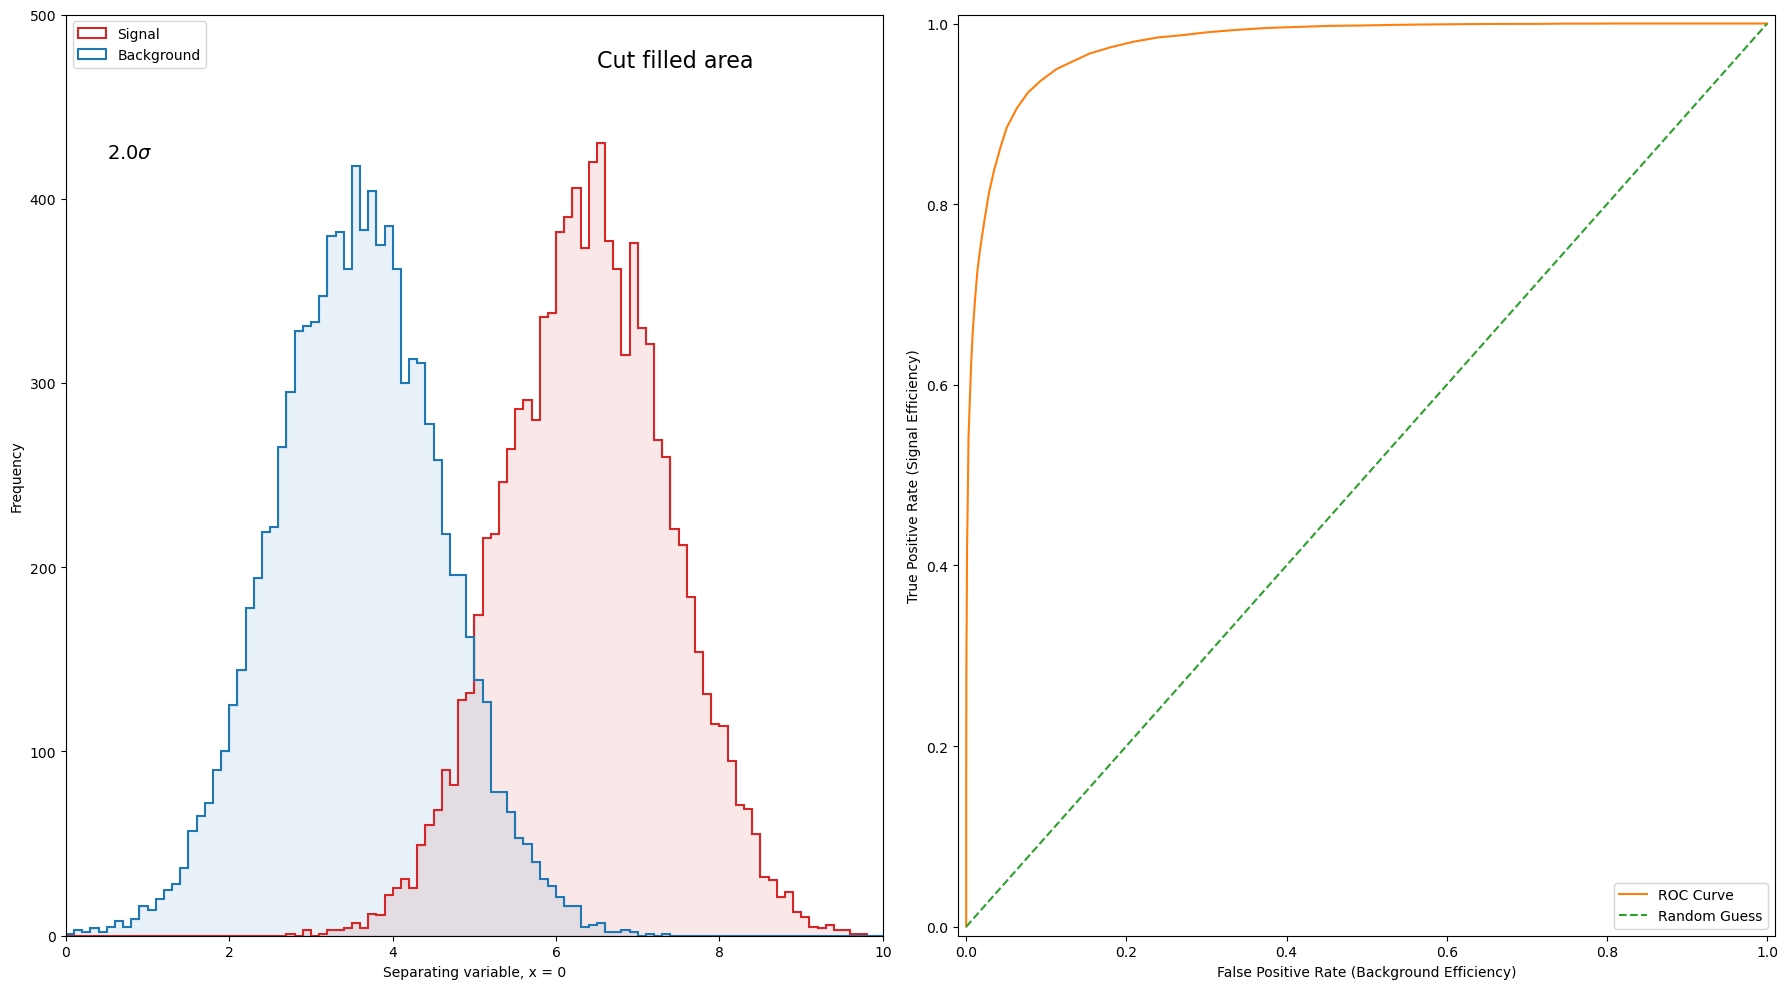

In [48]:
N_bins = 100
xmin, xmax = 0, 10
ymin, ymax = 0, 500

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,10))

hist_sig = ax[0].hist(random_sig, bins=N_bins, range=(xmin, xmax), histtype='step', label='Signal', color='C3', lw=1.5)
hist_bkg = ax[0].hist(random_bkg, bins=N_bins, range=(xmin, xmax), histtype='step', label='Background', color='C0', lw=1.5)

ax[0].text(0.05, 0.85, r'{:1.1f}$\sigma$'.format(N_sigma), size=14, verticalalignment='center', transform=ax[0].transAxes)
ax[0].text(0.65, 0.95, "Cut filled area", size=16, verticalalignment='center', transform=ax[0].transAxes)

ax[0].set(xlim=(xmin, xmax), ylim=(ymin, ymax), ylabel='Frequency')
ax[0].legend(loc='upper left')

FPR, TPR, x_centers, y_sig, y_bkg = calc_ROC(hist_sig, hist_bkg)
x_hist_interp, y_sig_interp, binwidth = interpolate_histogram(x_centers, y_sig, N=10_000)
x_hist_interp, y_bkg_interp, binwidth = interpolate_histogram(x_centers, y_bkg, N=10_000)

ax[1].plot(FPR, TPR, '-', label='ROC Curve', color='C1')
ax[1].plot([0, 1], [0, 1], '--', label='Random Guess', color='C2')

ax[1].set(xlabel='False Positive Rate (Background Efficiency)', 
          ylabel='True Positive Rate (Signal Efficiency)', 
          xlim=(-0.01, 1.01),
          ylim=(-0.01, 1.01),
         )

ax[1].legend()
fig.tight_layout()

ax[0].set(xlabel=f'Separating variable, x = 0')

line, = ax[0].plot([], [], '--k', alpha=0.4)
dot,  = ax[1].plot([], [], 'ok')

ax[0].fill_between(x_hist_interp, y_sig_interp, alpha=0.1, color='C3')
ax[0].fill_between(x_hist_interp, y_bkg_interp, alpha=0.1, color='C0');

patches = ax[0].patches
N_patches = len(patches)

## Animation

Below is an animation of the above figure, where you can directly see how you get from two histograms to a ROC curve.

In [49]:
# Initialization function: plot the background of each frame
def init():
    dot.set_data([], [])
    line.set_data([], [])
    
    while len(patches) > N_patches:
        patches.pop()
    
    return dot, line,  

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    
    if verbose and i>0:
        print(f'timestep {i}')
        
    dot.set_data(FPR[i], TPR[i])
    line.set_data([x_centers[i], x_centers[i]], [0, ymax])
    
    ax[0].set(xlabel=f'Separating variable, x = {x_centers[i]:.3f}')

    fill_histograms(i)
    
    return dot, line, 

In [50]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import pickle
import os

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = FuncAnimation(fig, animate, init_func=init, frames=N_bins-1, interval=50, blit=True)
plt.close(anim._fig)

filename = 'animation_ROC_figure.pkl'

if os.path.isfile(filename):
    with open(filename,'rb') as infile:
        animation_rendered = pickle.load(infile)    

else:
    animation_rendered = HTML(anim.to_jshtml())
    with open(filename,'wb') as outfile:
        pickle.dump(animation_rendered, outfile)


In [55]:
### use matplotlib to create a gif
anim.save('animation_ROC_figure.gif', writer='imagemagick', fps=10)


MovieWriter imagemagick unavailable; using Pillow instead.
